<a href="https://colab.research.google.com/github/Mohit-Mithra/ceiling-graph/blob/main/graphmem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

afrom google.colab import drive
drive.mount('/content/drive')
!pwd
%cd drive/My Drive/ceiling-graphs/TGN_ablation/TGN

Mounted at /content/drive
/content
/content/drive/My Drive/ceiling-graphs/TGN_ablation/TGN


In [ ]:
!python -c "import torch; print(torch.version.cuda)"
!python -c "import torch; print(torch.__version__)"

10.1
1.7.0+cu101


In [ ]:
%%capture
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!!pip install git+https://github.com/rusty1s/pytorch_geometric.git

In [ ]:
import os.path as osp

import torch
from torch.nn import Linear, LSTM
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score

from torch_geometric.datasets import JODIEDataset
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (LastNeighborLoader, IdentityMessage, LastAggregator)

In [ ]:
import os.path as osp

import torch
import pandas
from torch_geometric.data import InMemoryDataset, TemporalData, download_url

class genericDataset(InMemoryDataset):

    def __init__(self, root, name, transform=None, pre_transform=None):
        self.name = name.lower()
        assert self.name == 'random'

        super(genericDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self):
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self):
        return f'{self.name}.csv'

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        pass

    def process(self):
        df = pandas.read_csv(self.raw_paths[0], skiprows=1, header=None)

        src = torch.from_numpy(df.iloc[:, 0].values).to(torch.long)
        dst = torch.from_numpy(df.iloc[:, 1].values).to(torch.long)
        dst += int(src.max()) + 1
        t = torch.from_numpy(df.iloc[:, 2].values).to(torch.long)
        y = torch.from_numpy(df.iloc[:, 3].values).to(torch.long)
        msg = torch.from_numpy(df.iloc[:, 4:].values).to(torch.float)

        data = TemporalData(src=src, dst=dst, t=t, msg=msg, y=y)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self):
        return f'{self.name.capitalize()}()'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join('..', 'data', 'JODIE')
dataset = genericDataset(path, name='random')
data = dataset[0].to(device)

# Ensure to only sample actual destination nodes as negatives.
min_dst_idx, max_dst_idx = int(data.dst.min()), int(data.dst.max())

train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)

Processing...
Done!


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# path = osp.join('..', 'data', 'JODIE')
# dataset = JODIEDataset(path, name='wikipedia')
# data = dataset[0].to(device)

# min_dst_idx, max_dst_idx = int(data.dst.min()), int(data.dst.max())

# train_data, val_data, test_data = data.train_val_test_split(
#     val_ratio=0.15, test_ratio=0.15)

# neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)

In [ ]:
from torch_geometric.nn.inits import zeros

class global_memory(torch.nn.Module):
    def __init__(self, in_channel, global_mem_dimension):
        super(global_memory, self).__init__() 
        self.lin_global1 = Linear(in_channel*2, in_channel*2)
        self.lin_global2 = Linear(in_channel*2, global_mem_dimension)

    def forward(self, src_embedding, dst_embedding):
        inp = torch.cat((src_embedding, dst_embedding), dim=1)
        global_embedding = self.lin_global1(inp)
        global_embedding = self.lin_global2(global_embedding)
        # print('Global embedding shape')
        # print(global_embedding.size())
        return global_embedding


class global_memory_lstm(torch.nn.Module):
    def __init__(self, in_channel, hidden_dim, embedding_size):
        super(global_memory_lstm, self).__init__() 
        self.hidden_dim = hidden_dim
        self.h = torch.zeros(1, 1, hidden_dim).cuda()
        self.c = torch.zeros(1, 1, hidden_dim).cuda()
        self.lstm_out = torch.zeros(200, 1, hidden_dim).cuda()
        self.lstm = LSTM(in_channel*2, hidden_dim)
        self.linear = Linear(hidden_dim, embedding_size)

    def forward(self, src_embedding, dst_embedding):
        inp = torch.cat((src_embedding, dst_embedding), dim=1)
        lstm_out, (self.h, self.c) = self.lstm(inp.view(len(inp), 1, -1), (self.h, self.c))
        # print(lstm_out.size())
        embedding = self.linear(lstm_out.view(len(inp), -1))
        return embedding

    def reset_state(self):
        zeros(self.h)
        zeros(self.c)
        zeros(self.lstm_out)

    def detach(self):
        self.h.detach_()
        self.c.detach_()
        self.lstm_out.detach_()


class global_lstmcell(torch.nn.Module):
    def __init__(self, in_channel, hidden_dim, embedding_size):
        super(global_lstmcell, self).__init__() 
        self.hidden_dim = hidden_dim
        self.h = torch.zeros(1, hidden_dim).cuda()
        self.gru = torch.nn.GRUCell(in_channel*2, hidden_dim)
        self.linear = Linear(hidden_dim, embedding_size)

    def forward(self, src_embedding, dst_embedding):
        inp = torch.cat((src_embedding, dst_embedding), dim=1)

        output = torch.zeros(inp.size()[0], self.hidden_dim).cuda()

        for i in range(inp.size()[0]):
            self.h = self.gru(inp[i].view(1, -1), self.h)
            output[i] = self.h

        # print(self.h.size())
        embedding = self.linear(output.view(len(inp), -1))
        return embedding

    def reset_state(self):
        self.gru.reset_parameters()
        zeros(self.h)    

    def detach(self):
        self.h.detach_()

In [ ]:
import numpy as np

class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super(GraphAttentionEmbedding, self).__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                    dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)


class LinkPredictor_global(torch.nn.Module):
    def __init__(self, in_channels, global_in_channel):
        super(LinkPredictor_global, self).__init__()
        self.lin_src = Linear(in_channels+global_in_channel, in_channels+global_in_channel)
        self.lin_dst = Linear(in_channels+global_in_channel, in_channels+global_in_channel)
        self.lin_final = Linear(in_channels+global_in_channel, 1)

    def forward(self, z_src, z_dst, z_global):
        h = self.lin_src(torch.cat((z_src, z_global), dim=1)) + self.lin_dst(torch.cat((z_dst, z_global), dim=1))
        # print(h.size())
        h = h.relu()
        return self.lin_final(h)

class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super(LinkPredictor, self).__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)


memory_dim = time_dim = embedding_dim = 100
global_mem_dim = 100
hidden_dim = 100

memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)

#global_mem = global_memory(embedding_dim, global_mem_dim).to(device)
# global_mem = global_memory_lstm(embedding_dim, global_mem_dim, global_mem_dim).to(device)
global_mem = global_lstmcell(embedding_dim, hidden_dim, global_mem_dim).to(device)



# link_pred = LinkPredictor(in_channels=embedding_dim).to(device)
link_pred = LinkPredictor_global(in_channels=embedding_dim, global_in_channel = global_mem_dim).to(device)

optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters()) | set(global_mem.parameters())
    | set(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)

In [ ]:
def train():
    memory.train()
    gnn.train()
    link_pred.train()
    global_mem.train()

    memory.reset_state()  # Start with a fresh memory.
    neighbor_loader.reset_state()  # Start with an empty graph.
    global_mem.reset_state() #start with a fresh graph memory

    total_loss = 0
    total_global_loss = 0
    for batch in train_data.seq_batches(batch_size=200):
        optimizer.zero_grad()

        src, pos_dst, t, msg = batch.src, batch.dst, batch.t, batch.msg

        # Sample negative destination nodes.
        neg_dst = torch.randint(min_dst_idx, max_dst_idx + 1, (src.size(0), ),
                                dtype=torch.long, device=device)

        n_id = torch.cat([src, pos_dst, neg_dst]).unique()
        n_id, edge_index, e_id = neighbor_loader(n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Get updated memory of all nodes involved in the computation.
        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id], data.msg[e_id])

        z_global_pos = global_mem(z[assoc[src]], z[assoc[pos_dst]])
        z_global_neg = global_mem(z[assoc[src]], z[assoc[neg_dst]])

        # pos_out = link_pred(z[assoc[src]], z[assoc[pos_dst]])
        # neg_out = link_pred(z[assoc[src]], z[assoc[neg_dst]])

        pos_out = link_pred(z[assoc[src]], z[assoc[pos_dst]], z_global_pos)
        neg_out = link_pred(z[assoc[src]], z[assoc[neg_dst]], z_global_neg)

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))

        # Update memory and neighbor loader with ground-truth state.
        memory.update_state(src, pos_dst, t, msg)
        neighbor_loader.insert(src, pos_dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        global_mem.detach()
        
        total_loss += float(loss) * batch.num_events
    return total_loss / train_data.num_events

In [ ]:
@torch.no_grad()
def test(inference_data):
    memory.eval()
    gnn.eval()
    link_pred.eval()
    global_mem.eval()

    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

    aps, aucs, acc = [], [], []
    for batch in inference_data.seq_batches(batch_size=200):
        src, pos_dst, t, msg = batch.src, batch.dst, batch.t, batch.msg

        neg_dst = torch.randint(min_dst_idx, max_dst_idx + 1, (src.size(0), ),
                                dtype=torch.long, device=device)

        n_id = torch.cat([src, pos_dst, neg_dst]).unique()
        n_id, edge_index, e_id = neighbor_loader(n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)


        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id], data.msg[e_id])

        z_global_pos = global_mem(z[assoc[src]], z[assoc[pos_dst]])
        z_global_neg = global_mem(z[assoc[src]], z[assoc[neg_dst]])
 
        pos_out = link_pred(z[assoc[src]], z[assoc[pos_dst]], z_global_pos)
        neg_out = link_pred(z[assoc[src]], z[assoc[neg_dst]], z_global_neg)

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat(
            [torch.ones(pos_out.size(0)),
             torch.zeros(neg_out.size(0))], dim=0)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))
        acc.append(accuracy_score(y_true, y_pred.round()))

        memory.update_state(src, pos_dst, t, msg)
        neighbor_loader.insert(src, pos_dst)
        
    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean()), float(torch.tensor(acc).mean())


In [ ]:
val_ap_list = []
test_ap_list = []
val_acc_list = []
test_acc_list = []
for epoch in range(1, 20):
    loss = train()
    print(f'  Epoch: {epoch:02d}, Loss: {loss:.4f}')
    val_ap, val_auc, val_acc = test(val_data)
    test_ap, test_auc, test_acc = test(test_data)
    val_ap_list.append(val_ap)
    test_ap_list.append(test_ap)
    print(f' Val AP: {val_ap:.4f},  Val AUC: {val_auc:.4f}, Val Acc: {val_acc:.4f} ')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}, Test Acc: {test_acc:.4f}')

  Epoch: 01, Loss: 1.3865
 Val AP: 0.5168,  Val AUC: 0.5097, Val Acc: 0.5063 
Test AP: 0.5121, Test AUC: 0.5047, Test Acc: 0.5029
  Epoch: 02, Loss: 1.3865
 Val AP: 0.5068,  Val AUC: 0.4991, Val Acc: 0.4976 
Test AP: 0.5000, Test AUC: 0.4925, Test Acc: 0.4992
  Epoch: 03, Loss: 1.3864
 Val AP: 0.5082,  Val AUC: 0.5012, Val Acc: 0.4947 
Test AP: 0.5060, Test AUC: 0.4985, Test Acc: 0.4996
  Epoch: 04, Loss: 1.3864
 Val AP: 0.5071,  Val AUC: 0.5001, Val Acc: 0.4967 
Test AP: 0.5045, Test AUC: 0.4961, Test Acc: 0.4975
  Epoch: 05, Loss: 1.3864
 Val AP: 0.5100,  Val AUC: 0.5019, Val Acc: 0.4967 
Test AP: 0.5048, Test AUC: 0.4968, Test Acc: 0.4984
  Epoch: 06, Loss: 1.3864
 Val AP: 0.5112,  Val AUC: 0.5029, Val Acc: 0.4969 
Test AP: 0.5043, Test AUC: 0.4952, Test Acc: 0.4985
  Epoch: 07, Loss: 1.3865
 Val AP: 0.5096,  Val AUC: 0.5042, Val Acc: 0.5011 
Test AP: 0.5020, Test AUC: 0.4952, Test Acc: 0.4950
  Epoch: 08, Loss: 1.3864
 Val AP: 0.5112,  Val AUC: 0.5045, Val Acc: 0.4981 
Test AP: 0.5

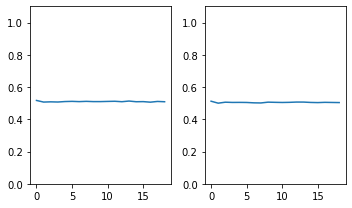

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].plot(val_ap_list)
axes[1].plot(test_ap_list)
axes[0].set_ylim([0, 1.1])
plt.ylim(ymin=0, ymax=1.1)
fig.tight_layout()
plt.show()

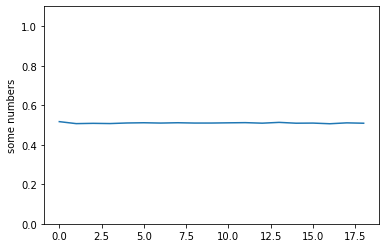

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(val_ap_list)
plt.ylabel('some numbers')
plt.ylim(ymin=0, ymax=1.1)
plt.show()
